In [12]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm
import datetime
import pandas as pd

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib
theano.config.optimizer='fast_run'
theano.config.floatX = "float64"

# Legend-formating for matplotlib
def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner


In [13]:
def plain_SIR_model(beta,gamma,N,S0,I0,R0,l=150):
    """Simple classical SIR-Model with time-constant beta,gamma"""
    def next_day(t,St,It,Rt,oS,oI,oR,eff,beta,gamma,N):
        eff = beta*St/N
        bSIoN = eff * It # -beta * (S*I)/N
        gI = gamma*It
        # Calculate differences
        dS = -bSIoN
        dI = bSIoN - gI
        dR = gI
        # Update values
        nxt_St = St + dS
        nxt_It = It + dI
        nxt_Rt = Rt + dR
        
        nxt_St = tt.clip(nxt_St,0,1e16) # Improves sampling stability
        
        # Pass on to next step
        return nxt_St,nxt_It,nxt_Rt, dS,dI,dR, eff
        
    # Initial internal state
    zero = tt.cast(0.,dtype='float64')
    initial_state = [S0,I0,R0,zero,zero,zero,zero]
    sequences = [tt.arange(l)]
    # Exceute the 'Loop'
    state,_ = theano.scan(fn=next_day,
                            sequences=sequences,# time dependent sequences can be passed as first params
                            outputs_info=initial_state,
                            non_sequences=[beta,gamma,N-I0-R0])
    return state


def Gompertz(a,b,c,l=150):
    """Self-explainatory."""
    t = tt.arange(l)
    return a*tt.exp(-b*tt.exp(-c*t))

# Wrappers to allow user of theano-code outside of pymc3
b,g,n,i0 = tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64")
i = tt.scalar(dtype="int64")
z = tt.constant(0.,dtype='float64')
S_t,I_t,R_t,dS,dI,dR,eff = plain_SIR_model(b,g,n,n,i0,z,i)
sir_f = theano.function(inputs=[b,g,n,i0,i],outputs=[S_t,I_t,R_t,dS])

a,b,c,offset = tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64")
i = tt.scalar(dtype="int64")
est = Gompertz(a,b,c,l=i,o=offset)
gomp_f = theano.function(inputs=[a,b,c,i,offset],outputs=[est])


In [15]:
# Data from
#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
#Germany,51.165690999999995,10.451526,
jhu_deaths = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,3,7,9,11,17,24,28,44,67,84,94,123,157,206,267,342,433,533,645,775,920,1107,1275,1444,1584,1810,2016,2349,2607,2767,2736,3022,3194,3294,3804,4052,4352,4459,4586,4862,5033,5279,5575,5760,5877,5976,6126,6314,6467,6623,6736,6812,6866,6993,6993,7275,7392,7510,7549,7569,7661,7738,7861,7884,7897,7938,7962,8003,8081,8144,8203,8228,8261,8283,8309,8372,8428,8470,8504,8530,8540,8555,8563,8602,8635,8658,8673,8685,8695,8736,8752,8772,8783,8793,8801,8807,8820,8851,8875,8887,8895,8895,8899,8914,8928,8940,8965,8968,8968,8976,8990,8995,9006,9010,9020,9023,9022,9032,9046,9057,9063,9070,9071,9074,9078,9080,9087,9088,9091,9092,9094,9099,9102,9110,9120,9124,9124,9125,9131,9135,9144,9147,9154,9154,9154,9163,9179,9181,9195,9201,9202,9203,9208,9213,9217,9230,9235,9235,9236,9241,9249,9263,9266,9272,9275,9276,9281,9285,9290,9290,9299]
jhu_ts = pd.date_range(datetime.date(2020,1,21),periods=len(jhu_deaths),freq='D')

# Limit to non-zero values, dropping the front of the list
first_non_zero_index = 47
jhu_deaths1 = jhu_deaths[first_non_zero_index:]
jhu_ts1 = jhu_ts[first_non_zero_index:]
print("first non zero deaths timestamp",jhu_ts1[0])

# Alternative Deaths from Situation-report graph of actual dates of deaths
rki_deaths_per_day = [1, 1, 1, 1, 5, 2, 3, 4, 11, 13, 12, 21, 40, 24, 42, 42, 67, 76, 92, 104, 107, 114, 172, 165, 162, 204, 199, 223, 240, 240, 254, 260, 257, 240, 246, 239, 243, 245, 227, 239, 241, 191, 203, 209, 172, 194, 157, 163, 129, 141, 132, 125, 128, 121, 106, 76, 92, 78, 93, 82, 69, 54, 63, 64, 63, 42, 54, 66, 47, 29, 40, 44, 45, 47, 31, 33, 27, 30, 31, 23, 21, 18, 19, 17, 18, 24, 15, 18, 18, 14, 8, 9, 8, 6, 11, 11, 14, 9, 6, 9, 7, 7, 9, 6, 3, 4, 4, 6, 7, 7, 7, 4, 7, 8, 1]
rki_deaths = np.cumsum(rki_deaths_per_day)
rki_ts = pd.date_range(datetime.date(2020,3,8),periods=len(rki_deaths),freq='D')

sources = {"jhu":(jhu_deaths,jhu_ts),"jhu1":(jhu_deaths1,jhu_ts1),"rki":(rki_deaths,rki_ts)}

data,ts = sources["jhu1"]

print(ts)
print(data[:20])

#t_lables = []

first non zero deaths timestamp 2020-03-08 00:00:00
DatetimeIndex(['2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11',
               '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
               '2020-03-16', '2020-03-17',
               ...
               '2020-08-19', '2020-08-20', '2020-08-21', '2020-08-22',
               '2020-08-23', '2020-08-24', '2020-08-25', '2020-08-26',
               '2020-08-27', '2020-08-28'],
              dtype='datetime64[ns]', length=174, freq='D')
[2, 2, 3, 3, 7, 9, 11, 17, 24, 28, 44, 67, 84, 94, 123, 157, 206, 267, 342, 433]


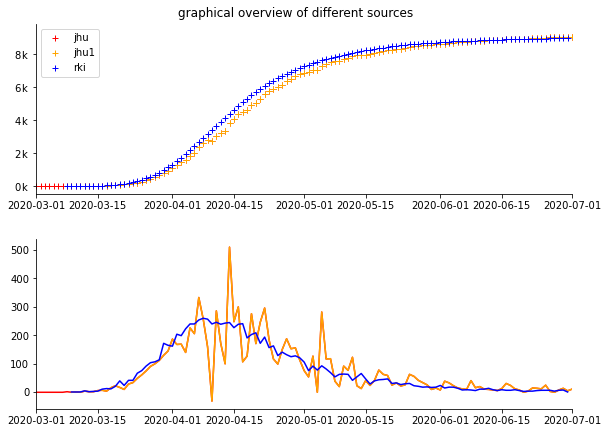

In [16]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.05,right=0.98,top=0.94,bottom=0.05)
fig.suptitle("graphical overview of different sources")
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0,0])
bx = fig.add_subplot(gs[1,0])

i = 0
color=["red","orange","blue"]
for k,v in sources.items():
   
    d,t = v
    ax.plot(t,d,'+',label=k,color=color[i])
    bx.plot(t[1:],np.diff(d),label=k,color=color[i])
    i+=1
    
ax.set_xlim([datetime.date(2020,3,1),datetime.date(2020,7,1)])
bx.set_xlim([datetime.date(2020,3,1),datetime.date(2020,7,1)])
ax.legend()
    
for tx in [ax,bx]:
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    if prec < 2.0 and prec >= 0:
        tx.yaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        )
    tx.spines['top'].set_visible(False)
    tx.spines['right'].set_visible(False)
        

In [6]:
# Test simple SIR-Fit beta,gamma,N,I0

def FitSIRModel(data,l=90,initial={},fit_I0=True,fit_differences=False):
    """
    Fit SIR model using HamiltonianMonteCarlo No-UTurn-Sampler 
        fit_0 : Allow fitting I0 else I0 = 1
        fit_differences : False # keep it that way until daily differences are of interest and not total numbers
    """
    with pm.Model() as model:
        # Setup Priors for beta,gamma
        beta = pm.Lognormal(name="beta",
                        mu=tt.log(tt.cast(.4,dtype='float64')),
                        sigma=tt.cast(.4,dtype='float64')) # Choose both beta and gamma wide enough
        gamma = pm.Lognormal(name="gamma",
                         mu=tt.log(tt.cast(.13,dtype='float64')),
                         sigma=tt.cast(.3,dtype='float64'))
        beta = tt.clip(beta,gamma,1e3) # Ensure positive initial growth, improves sampling
    
#        N = tt.cast(83e6,dtype='float64')
        N = pm.Lognormal(name="N",mu=tt.log(tt.cast(10000,dtype='float64')),sigma=tt.cast(.95,dtype='float64'))
        S0 = N
        if fit_I0: # Eiher fit or don't fit I0
            I0 = pm.Lognormal(name="I0",
                      mu=tt.log(tt.cast(1.,dtype='float64')),
                      sigma=tt.cast(.5,dtype="float64")
                     )
        else:
            I0 = tt.cast(1,dtype='float64')
    
        R0 = tt.cast(0.,dtype='float64')
    
        # Run the Model
        S_t,I_t,R_t,dS,dI,dR,eff = plain_SIR_model(beta,gamma,N,S0,I0,R0,l=l)
        # Store Model output in Trace
        pm.Deterministic("S_t",S_t)
        pm.Deterministic("I_t",I_t)
        pm.Deterministic("R_t",R_t)
        pm.Deterministic("dR",dR)
        pm.Deterministic("dS",dS)
        
        # Loglike-estimate
        if fit_differences: # Fit differences, which might me more suitable for the Sampler
            est_deaths = dR
            sigma_obs = pm.HalfCauchy( name="sigma", beta=10 )
            pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est_deaths,
                    sigma=tt.abs_(est_deaths + 1) ** 0.5 * sigma_obs,
                    observed=np.diff(deaths1[:l+1])
            )
        else: # Leads to tighter fit to the non-differentiated data
            est_deaths = R_t
            sigma_obs = pm.HalfCauchy( name="sigma", beta=50 )
            pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est_deaths,
                    sigma=tt.abs_(est_deaths + 1) ** 0.5 * sigma_obs,
                    observed=data[:l]
            )
        
        # Handle Chained sampling reusing previous fit as starting-point
        init = "advi+adapt_diag" if len(initial) == 0 else None
        trace = pm.sample( model=model,init=init,start=initial,draws=100,tune=100,cores=4,chains=4)#,max_treedepth=16)
        return trace

In [17]:
print(data[:20])
trace = FitSIRModel(data,l=10)

[2, 2, 3, 3, 7, 9, 11, 17, 24, 28, 44, 67, 84, 94, 123, 157, 206, 267, 342, 433]


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 9800
Interrupted at 9,799 [4%]: Average Loss = 44.902
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 65 seconds.
The acceptance probability does not match the target. It is 0.6341836010761595, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6616937109367265, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [19]:
np.mean(trace.R_t,axis=0)

array([ 0.63606649,  1.47107205,  2.5688766 ,  4.01438899,  5.92068389,
        8.43857297, 11.76947707, 16.18271972, 22.03869811, 29.81976391])

In [10]:
def SIRSeries(data,start=15,end=30,fit_I0=True):
    estimates = {}
    tr = None
    for l in range(start,end+1):
        initial = {} if tr == None else {'beta':np.mean(tr.beta),'gamma':np.mean(tr.gamma),'N':np.mean(tr.N)}
        if fit_I0 and tr != None:
            initial['I0'] = np.mean(tr.I0)
            
        tr = FitSIRModel(data=data,l=l,initial=initial,fit_I0=fit_I0)
        estimates[l] = {'beta':tr.beta,'gamma':tr.gamma,'N':tr.N,}
        if fit_I0:
            estimates[l]["I0"] = tr.I0
    return estimates

sir_est = SIRSeries(data,15,30)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 10900
Interrupted at 10,899 [5%]: Average Loss = 77.806
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 106 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 129 seconds.
The acceptance probability does not match the target. It is 0.6878842390620065, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 174 seconds.
The acceptance probability does not match the target. It is 0.6863237148996162, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6985608288747795, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 173 seconds.
The acceptance probability does not match the target. It is 0.5318678215339798, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 200 seconds.
The acceptance probability does not match the target. It is 0.4031469578647677, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6403269629862597, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6225904952532769, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 266 seconds.
The acceptance probability does not match the target. It is 0.5676379272002202, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 283 seconds.
The acceptance probability does not match the target. It is 0.6704781161303498, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 314 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 348 seconds.
The acceptance probability does not match the target. It is 0.5178503957644824, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5119341817462828, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 364 seconds.
The acceptance probability does not match the target. It is 0.6017960241157728, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.686160026217073, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 417 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 427 seconds.
The acceptance probability does not match the target. It is 0.6890000219709218, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 473 seconds.
The acceptance probability does not match the target. It is 0.2689881364055685, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7214573888570371, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 494 seconds.
The acceptance probability does not match the target. It is 0.5822089045373335, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6588725443768345, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 437 seconds.
The acceptance probability does not match the target. It is 0.4884594273664622, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6917539660987352, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 469 seconds.
The acceptance probability does not match the target. It is 0.7150442236128951, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
with open("estimates/sir_%d"%time.time(),"wb+") as f:
    pickle.dump(sir_est,f)

for k,v in sir_est.items():
    print(k,v["ssd"])
    for p in ['beta','gamma','N','I0']:
        print("\t",p,np.mean(v[p]),np.percentile(v[p],q=(2.5,5,50,95,97.5)))

15 312.82843288520417
	 beta 0.5177373155559134 [0.42910787 0.44068221 0.5140565  0.60723292 0.62771026]
	 gamma 0.18958117529628238 [0.11056827 0.11924079 0.18458145 0.27992938 0.2959447 ]
	 N 13749.524950538937 [  778.06872959  1227.14225249  8216.57628041 43294.26983065
 58066.58644669]
	 I0 3.608021014250623 [2.08185123 2.25302817 3.47202176 5.52757587 6.01963446]
16 327.07610572964626
	 beta 0.5097003013427857 [0.42488444 0.43481549 0.50367511 0.60290855 0.61797292]
	 gamma 0.19121521911117595 [0.11293525 0.12092113 0.18372    0.28584412 0.30456598]
	 N 11607.323728740543 [  643.50132673   816.95454405  6246.65315742 41733.28405771
 54991.916654  ]
	 I0 3.759552983615609 [2.23090018 2.33711993 3.65633907 5.64879436 6.06463523]
17 323.272010352944
	 beta 0.4992281781935031 [0.42525581 0.43479148 0.49357446 0.58161113 0.60709015]
	 gamma 0.18600728617518178 [0.1132247  0.12432971 0.18010243 0.26505645 0.29624828]
	 N 11349.457387653316 [  880.07056796  1108.2794558   6053.90468323 4

In [7]:
def FitGompertz(data,l=90,initial={}):
    with pm.Model() as model:
        a = pm.Lognormal(name="a",
                    mu=tt.log(tt.cast(1e5,dtype='float64')),
                    sigma=tt.cast(.6,dtype='float64'))
        b = pm.Lognormal(name="b",
                    mu=tt.log(tt.cast(11,dtype='float64')),
                    sigma=tt.cast(.8,dtype='float64'))
        c = pm.Lognormal(name="c",
                    mu=tt.log(tt.cast(.07,dtype='float64')),
                    sigma=tt.cast(.8,dtype='float64'))
    
        est = Gompertz(a,b,c,l)
        est_deaths = pm.Deterministic("deaths",est)
    
        sigma_obs = pm.HalfCauchy( name="sigma", beta=40 )
        pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est_deaths,
                    sigma=tt.abs_(est_deaths + 1) ** 0.5 * sigma_obs,
                    observed=data[:l]
        )
        init = "advi+adapt_diag" if len(initial) == 0 else None
        trace = pm.sample( model=model,init=init,start=initial,draws=1200,tune=2000,cores=4,chains=4)
        return trace

In [ ]:
trace = FitGompertz(data,l=80)

In [8]:
def GompertzSeries(data,start=30,end=120):
    estimates = {}
    tr = None
    for l in range(start,end+1):
        initial = {} if tr == None else {'a':np.mean(tr.a),'b':np.mean(tr.b),'c':np.mean(tr.c)}
        tr = FitGompertz(data,l=l,initial=initial)
        ssd = np.sum(np.power(data[:l]-np.mean(tr.deaths,axis=0),2))
        estimates[l] = {'a':tr.a,'b':tr.b,'c':tr.c,"ssd":ssd}
    return estimates

gomp_est = GompertzSeries(data,15,30)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 3600
Interrupted at 3,599 [1%]: Average Loss = 98.231
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 41 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.6939710747914484, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.5944801250493925, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6928642951861752, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7191396419852443, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7118622793190326, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 38 seconds.
The acceptance probability does not match the target. It is 0.6774427456357305, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 40 seconds.
The acceptance probability does not match the target. It is 0.6794507917623711, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7194061690645979, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 43 seconds.
The acceptance probability does not match the target. It is 0.671924905912841, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 47 seconds.
The acceptance probability does not match the target. It is 0.6871070359903363, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5771831569563998, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 50 seconds.
The acceptance probability does not match the target. It is 0.6741743382205944, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6502908634614639, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 49 seconds.
The acceptance probability does not match the target. It is 0.6010747473481111, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.663600416360203, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 56 seconds.
The acceptance probability does not match the target. It is 0.5391930104571017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6759431999772719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855894908908086, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 54 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 56 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 52 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 46 seconds.
The acceptance probability does not match the target. It is 0.7093014481251351, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 47 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 43 seconds.
The acceptance probability does not match the target. It is 0.9340713192626917, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910814084400807, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
with open("estimates/gomp_%d"%time.time(),"wb+") as f:
    pickle.dump(gomp_est,f)

for k,v in gomp_est.items():
    print(k,v["ssd"])
    for p in ['a','b','c']:
        print("\t",p,np.mean(v[p]),np.percentile(v[p],q=(2.5,5,50,95,97.5)))


15 218.97433808454005
	 a 105855.46948057046 [ 29594.82056049  35815.33138946  89863.78019881 227511.47393491
 269296.80605503]
	 b 11.173332927586427 [10.10525006 10.26848323 11.17408738 12.06282095 12.22530401]
	 c 0.038128797672783744 [0.03277298 0.03350192 0.03786778 0.04354894 0.04471327]
16 226.521971152024
	 a 94882.90557322468 [ 26372.07918844  32299.77378773  85281.52363064 191343.02959638
 224116.38583366]
	 b 11.062388287872164 [10.01630973 10.18266574 11.08418604 11.87205941 12.01495088]
	 c 0.0382248433636001 [0.0331813  0.03400983 0.03780903 0.04356172 0.0450514 ]
17 244.1790124454931
	 a 104797.631998202 [ 29167.43611537  32827.51118757  87220.9165751  221969.186802
 257321.57720161]
	 b 11.165952001479111 [10.11136344 10.23049203 11.14999975 12.00496889 12.11839215]
	 c 0.03803571799796545 [0.03275647 0.03351311 0.03793684 0.04378201 0.04494582]
18 318.56032207927865
	 a 124949.04480913247 [ 33672.67797903  40434.43445542 102879.74774246 307814.24246992
 339027.72849578

In [ ]:
trace = FitGompertz(l=30)
plt.plot(ts1[:l],deaths1[:l],"+")
plt.plot(ts1[:l],trace.deaths[0])
plt.fill_between(ts1[:l],*np.percentile(trace.deaths,axis=0,q=(2.5,97.5)),color="orange",alpha=.2)

gomp_est = np.mean(trace.deaths,axis=0)
print(SSD(deaths1[:1],gomp_est))
